In [1]:
from collections import deque
import gymnasium as gym
from gymnasium import spaces
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Topology():
    def __init__(self, n, model="random", density=1):
        self.n = n
        self.model = model
        self.density = density
        self.adjacency_matrix = self.make_adjacency_matrix()
        
    def make_adjacency_matrix(self) -> np.ndarray:
        """Make adjacency matrix of a clique network.
        Args:
            n (int): Number of nodes.
            density (float): Density of the clique network.

        Returns:
            np.ndarray: Adjacency matrix.
        """
        if self.density < 0 or self.density > 1:
            raise ValueError("Density must be between 0 and 1.")

        n_edges = int(self.n * (self.n - 1) / 2 * self.density)
        adjacency_matrix = np.zeros((self.n, self.n))

        if self.model == "dumbbell":
            adjacency_matrix[0, self.n-1] = 1
            adjacency_matrix[self.n-1, 0] = 1
            for i in range(1, self.n//2):
                adjacency_matrix[0, i] = 1
                adjacency_matrix[i, 0] = 1
            for i in range(self.n//2+1, self.n):
                adjacency_matrix[i-1, self.n-1] = 1
                adjacency_matrix[self.n-1, i-1] = 1
        elif self.model == "linear":
            for i in range(1, self.n):
                adjacency_matrix[i-1, i] = 1
                adjacency_matrix[i, i-1] = 1
        elif self.model == "random":
            for i in range(1, self.n):
                adjacency_matrix[i-1, i] = 1
                adjacency_matrix[i, i-1] = 1
                n_edges -= 1
            # If the density of the current adjacency matrix is over density, return it.
            if n_edges <= 0:
                return adjacency_matrix
            else:
                arr = [1]*n_edges + [0]*((self.n-1)*(self.n-2)//2 - n_edges)
                np.random.shuffle(arr)
                for i in range(0, self.n):
                    for j in range(i+2, self.n):
                        adjacency_matrix[i, j] = arr.pop()
                        adjacency_matrix[j, i] = adjacency_matrix[i, j]
        else:
            raise ValueError("Model must be dumbbell, linear, or random.")
        return adjacency_matrix

    def show_adjacency_matrix(self):
        print(self.adjacency_matrix)
        
    def get_density(self):
        return np.sum(self.adjacency_matrix) / (self.n * (self.n - 1))
    
    def save_graph_with_labels(self, path):
        rows, cols = np.where(self.adjacency_matrix == 1)
        edges = zip(rows.tolist(), cols.tolist())
        G = nx.Graph()
        G.add_edges_from(edges)
        pos = nx.kamada_kawai_layout(G)
        nx.draw_networkx(G, pos=pos, with_labels=True)
        plt.savefig(path + '/adj_graph.png')


class MFRLEnv(gym.Env):
    actions = np.array([])
    def __init__(self, agent):
        self.adj_num = agent.get_num_adjacent()
        self.adj_ids = agent.get_adjacent_ids()
        self.adj_obs = {adj_id: [0, 0] for adj_id in self.adj_ids}
        self.observation_space = spaces.Box(low=0, high=1, shape=(1, 2))
        self.action_space = spaces.Discrete(2)
        
    def reset(self, seed=None):
        super().reset(seed=seed)
        observation = np.array([0.5, 0.5])
        info = {}
        return observation, info
    
    def gather_actions(self, action):
        MFRLEnv.actions = np.append(MFRLEnv.actions, action)
        
    def calculate_meanfield(self):  
        # Return the meanfield observation
        if self.idle_check():
            return np.array([0, 1])
        else:
            return np.array(
                (self.adj_num*(2**self.adj_num)*np.array([0.5, 0.5]) - self.adj_num*np.array([1, 0])) 
                / (self.adj_num*(2**self.adj_num)-self.adj_num))

    def idle_check(self):
        # Check if all the adjacent agents are idle, based on MFRLEnv.actions
        if all(MFRLEnv.actions[self.adj_ids] == 0):
            return True
        else:
            return False
    
    def step(self, action):
        # self.adj_actions = {adj_id: MFRLEnv.actions[adj_id] for adj_id in self.adj_ids} # Hidden to the agent
        observation = self.calculate_meanfield()
        if action == 1 and self.idle_check():
            reward = 1
        else:
            reward = 0
        terminated = False
        info = {}
        return observation, reward, terminated, False, info


class Agent:
    def __init__(self, topology, id):
        self.topology = topology
        if id >= topology.n:
            raise ValueError("id must be less than n.")
        else:
            self.id = id
        self.env = MFRLEnv(self)
         
    def get_adjacent_ids(self):
        return np.where(self.topology.adjacency_matrix[self.id] == 1)[0]
    
    def get_adjacent_num(self):
        return len(self.get_adjacent_ids())

[[0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.]]


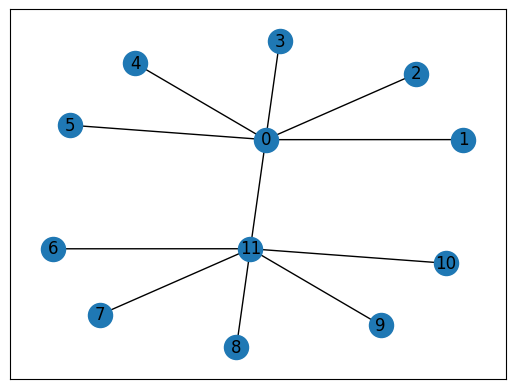

In [2]:
topo = Topology(12, "dumbbell", 0.5)
topo.show_adjacency_matrix()
topo.save_graph_with_labels(".")

In [3]:
agents = [Agent(topo, i) for i in range(topo.n)]
for agent in agents:
    print(agent.id)
    print(agent.get_adjacent_ids())
    print(agent.get_adjacent_num())
    print(agent.env.observation_space)
    print(agent.env.action_space)
    print("")

0
[ 1  2  3  4  5 11]
6
Box(0.0, 1.0, (6, 1), float32)
Discrete(2)

1
[0]
1
Box(0.0, 1.0, (1, 1), float32)
Discrete(2)

2
[0]
1
Box(0.0, 1.0, (1, 1), float32)
Discrete(2)

3
[0]
1
Box(0.0, 1.0, (1, 1), float32)
Discrete(2)

4
[0]
1
Box(0.0, 1.0, (1, 1), float32)
Discrete(2)

5
[0]
1
Box(0.0, 1.0, (1, 1), float32)
Discrete(2)

6
[11]
1
Box(0.0, 1.0, (1, 1), float32)
Discrete(2)

7
[11]
1
Box(0.0, 1.0, (1, 1), float32)
Discrete(2)

8
[11]
1
Box(0.0, 1.0, (1, 1), float32)
Discrete(2)

9
[11]
1
Box(0.0, 1.0, (1, 1), float32)
Discrete(2)

10
[11]
1
Box(0.0, 1.0, (1, 1), float32)
Discrete(2)

11
[ 0  6  7  8  9 10]
6
Box(0.0, 1.0, (6, 1), float32)
Discrete(2)



In [10]:
nu = np.array([])
nu = np.append(nu, 1)
print(nu)
nu = np.append(nu, 10)
print(nu)

[1.]
[ 1. 10.]
